In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import load_model

from tsmoothie.smoother import *


In [5]:

def nmser(x,y):
    z=0
    if len(x)==len(y):
        for k in range(len(x)):
            z = z + (((x[k]-y[k])**2)/x[k])    
            z = z/(len(x))
    return z[0]
    
def get_model(Xf,ysf,dataset='',dup='',kernel_size=2,dayahead = 1,look_back=3,lstm=50,conv1d=50,lr=0.001,l1=0,l2=0.01,epochs=100,conv_1d=False,lstm_=False):
    
    K.clear_session()
    
    model = Sequential()
    if lstm_:
        
        model.add
        (
            LSTM(

                lstm,

                return_sequences = True,

                recurrent_regularizer = l1_l2(l1 = l1, l2 = l2), 

                input_shape = (Xf.shape[1], Xf.shape[2])

                )
        )
     
    
    #output_shape = (batchsize, look_back,1) 
    if conv_1d:
        model.add(Conv1D(conv1d, kernel_size,input_shape = (Xf.shape[1], Xf.shape[2])))
        model.add(Conv1D(conv1d, kernel_size,input_shape = (Xf.shape[1], Xf.shape[2])))
    
    model.add(Flatten())

    model.add(Dense(dayahead))


    adm = tf.keras.optimizers.Adam(

        learning_rate = lr,

        amsgrad = True,

        name = "Adam"
    )

    model.compile(optimizer = adm, loss = 'mse')
    

    early_stop = EarlyStopping(monitor = 'loss', patience = 10, min_delta = 0)


    model.fit(
                Xf, ysf,

                epochs = epochs,

                verbose = 0,

                workers = 10,

                use_multiprocessing = True,

                callbacks = [early_stop]

    )
    
    
    model.save("modelday{}{}{}.h5".format(dayahead,dataset,dup))
    
    del model

def average(dfr, H = 24,typ = "AVG"):
    
    dft = dfr.copy()
    
    if typ == "MIN":
        
        for i  in range(0, dft.shape[0], H):
        
            dft[i:(i+H)] = dft[i:(i+H)].min()
    
        dft = dft[::H]
    
    elif typ == "MAX":
        
        for i  in range(0,dft.shape[0],H):
            
            dft[i:(i+H)] = dft[i:(i+H)].max()
    
        dft = dft[::H]
    
    elif typ == "AVG":
        
        for i  in range(0,dft.shape[0],H):
            
            dft[i:(i+H)] = dft[i:(i+H)].mean() 
    
        dft = dft[::H]

    return dft


def create_dataset(n_x, look_back = 1, look_ahead = 1):

    dataX, dataY = [], []
    
    n_X = np.array(n_x)
    
    
    for i in range(len(n_X)-look_ahead-look_back):
        
        dataX.append(n_x[i:(i+look_back)])
    
        dataY.append(n_x[(i + look_back):(i + look_back + look_ahead)])
           
        
    
    del look_ahead, look_back
   
    return np.array(dataX), np.array(dataY)


def Plot(testyz, predictz,single=False,look_ahead=1,sym='-',difference=False):
    
    
    avg = sum((testyz - predictz) ** 2) / testyz.shape[0]
    
    avg1 = sum(abs(testyz - predictz)) / testyz.shape[0]
    
    if look_ahead==1:
    
        avg, avg1 = avg[0], avg1[0]
    
    print('NMSE=',nmser(testyz,predictz),' MSE =',avg,' RMSE =',(avg)**(1/2),' MAE =',avg1)
    

   
    if not difference:

        for i in range(look_ahead):

            plt.figure(figsize = (15, 8));



            plt.plot(testyz, 'b{}'.format(sym), label = 'Real Value')

            plt.plot(predictz,'g{}'.format(sym), label = "day {} forcast".format(i+1))

            plt.plot(predictz - testyz, 'r{}'.format(sym),label = "error day{} forcast".format(i+1))

            plt.legend()

        plt.show()

        
def smoothing(dff,days=10):

    smoother = ConvolutionSmoother(window_len = days, window_type = 'ones')
  
    
    dff = pd.DataFrame(smoother.smooth(dff.copy().dropna()).smooth_data).T
    
    del smoother
    
    return dff



modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    
    monitor = "loss",
    
    filepath = "model_checkpoint_lstm.h5",
    
    verbose = 0, workers = 10, use_multiprocessing=True,
    
    save_weights_only = True,
    
    save_best_only = True,
)


def create_data(Xd,ysd,predtraind,Xtestd,ytestsd,predfd,look_back=5,look_ahead=1):
    
    Xd = np.concatenate(( Xd[:,-look_back:].reshape(-look_back,look_back), predtraind), axis=1)
    
    Xtestd = np.concatenate((Xtestd[:,-look_back:].reshape(-look_back,look_back), predfd ), axis=1)
    
    return Xd.reshape(Xd.shape[0],Xd.shape[1],1)[:-look_ahead],ysd[look_ahead:],Xtestd.reshape(Xtestd.shape[0],Xtestd.shape[1],1)[:-look_ahead],ytestsd[look_ahead:]


testing loss:
NMSE= 0.0006899983074694923  MSE = 1.1293509151459658  RMSE = 1.062709233584599  MAE = 0.8393161301107185


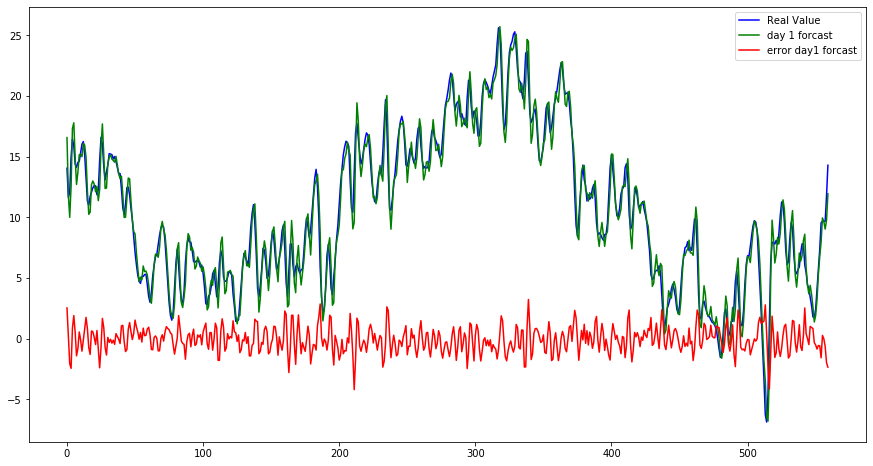

In [7]:
dataset = 'dataexport_20210403T021549.csv'
df_t = pd.read_csv("../datasets/{}".format(dataset))
df_f =  df_t.iloc[:,3]

ls=[]


lastreal = df_f.iloc[-1:]

#removing last day's prediction to keep it completetly unknown to model 
df_f = smoothing(df_f.iloc[:-1],days=1)

df_s = smoothing(df_f.copy(), days = 2)

prop = 20/21

look_back = 30
look_ahead = 1
trainlength = int(df_f.shape[0]*prop)-look_back


trainxs = df_s[:trainlength].copy()

testxs = df_s[trainlength:].copy()



trainx = np.array(df_f[:trainlength].copy())

testx = np.array(df_f[trainlength:].copy())


X,y = create_dataset(trainx.copy(),look_back=look_back)

Xs, ys = create_dataset(trainxs.copy(),look_back=look_back)


Xtest,ytest = create_dataset(testx.copy(),look_back=look_back)

Xtests,ytests = create_dataset(testxs.copy(),look_back=look_back)




get_model(Xs,y,dataset=dataset,look_back=look_back,lstm_=True)
#get_model(X,y,dataset=dataset,dup=dup,look_back=look_back,conv_1d=True,conv1d=100)

model = load_model("modelday{}{}.h5".format(look_ahead,dataset))

predf = model.predict(Xtests)
predtrain = model.predict(Xs)



print('testing loss:')
Plot(ytests.copy().reshape(predf.shape[0],1),predf.reshape(predf.shape[0],1),difference=False)


